# Imports and data load

In [2]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf 

from collections import Counter

In [3]:
#load data, working on a sample
df = pd.read_csv('../raw_data/train.csv')
df['discourse_type']=df['discourse_type'].replace('Concluding Statement','Concluding_Statement') ## for later
df.head(2)

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59


In [4]:
def is_not_sentence(text):
    if '.' not in text[-5:] or not text[0].isupper():
        return 0
    return 1

In [5]:
## let's check the proportion of sentences
df['is_not_sent']=df['discourse_text'].apply(is_not_sentence)
p = df['is_not_sent'].sum()/2/len(df)
print(f"There is approximatively {p*100:.2f}% of discourses not limited by a sentence")

There is approximatively 25.65% of discourses not limited by a sentence


# Preprocess the data

Objective = get the data at sentence level

In [6]:
#Pseudo code : 
# 1- create a match predictionstring-label-word
    # a) repeat label
    # b) groupby id / join 
    # c) match id/full text
    
# 2- go the other way around : from full text / ps / label to sentences / ps / label 
    # a) get the indice of the end of a sentence ; explode our dataset
    # b) split by this indice for ps and labels
    
# 3- choose a type for sentences with 2 types

In [7]:
def get_essay(id_,mode='train'):
    """Function to get the full text of an essay from the .txt file.

    Args:
        id_ (str): id of the essay
        mode (str, optional): determines whether to access *train* or *test* texts. \
        Defaults to 'train'.

    Returns:
        str: Returns the full text of the id
    """
    with open(os.path.join('../raw_data',mode,f'{id_}.txt'),'r') as file:
        txt = file.read()
    return txt.strip()

In [8]:
def repeater(label,txt):
    words=[]
    labels=[]
    for w in txt.split():
        if '.' in w[-2:]:
            labels.append(label+'.')
        else:
            labels.append(label)
    return ' '.join(labels)

repeater_vect = np.vectorize(repeater) #vectorize our function

df['labels'] = repeater_vect(df['discourse_type'],df['discourse_text']) #apply

In [9]:
df.head(1)

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,is_not_sent,labels
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,1,Lead Lead Lead Lead Lead Lead Lead Lead. Lead ...


In [10]:
#groupby
df_essay=df.groupby('id').agg({'predictionstring':' '.join,'labels':' '.join}).reset_index()
df_essay.head(1)

,id,predictionstring,labels
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...


In [11]:
#retrieve full text
df_essay['text']=df_essay['id'].apply(get_essay) #get essay full text for each id
df_essay.head(3)

,id,predictionstring,labels,text
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o..."
1,00066EA9880D,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Lead Lead Lead Lead Lead Lead Lead Lead Lead L...,Driverless cars are exaclty what you would exp...
2,000E6DE9E817,2 3 4 5 6 7 8 10 11 12 13 14 15 16 17 18 19 20...,Position Position Position Position Position P...,Dear: Principal\n\nI am arguing against the po...


In [12]:
## Get the indice ... how ? 

text = """Python (prononcé /pi.tɔ̃/) est un langage de programmation interprété, multi-paradigme et multiplateformes. Il favorise la programmation impérative structurée, fonctionnelle et orientée objet. Il est doté d'un typage dynamique fort, d'une gestion automatique de la mémoire par ramasse-miettes et d'un système de gestion d'exceptions ; il est ainsi similaire à Perl, Ruby, Scheme, Smalltalk et Tcl.

Le langage Python est placé sous une licence libre proche de la licence BSD4 et fonctionne sur la plupart des plates-formes informatiques, des smartphones aux ordinateurs centraux5, de Windows à Unix avec notamment GNU/Linux en passant par macOS, ou encore Android, iOS, et peut aussi être traduit en Java ou .NET. Il est conçu pour optimiser la productivité des programmeurs en offrant des outils de haut niveau et une syntaxe simple à utiliser."""

indices = [i for i, w in enumerate(text.split()) if '.' in w[-2:]]
indices

[11, 21, 54, 105, 127]

In [13]:
#apply func
df_essay['indices']=df_essay['text'].apply(lambda text : [i for i, w in enumerate(text.split()) if '.' in w[-2:]])
df_essay.head()

,id,predictionstring,labels,text,indices
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...","[15, 20, 33, 50, 68, 83, 116, 133, 139, 153, 1..."
1,00066EA9880D,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Lead Lead Lead Lead Lead Lead Lead Lead Lead L...,Driverless cars are exaclty what you would exp...,"[10, 27, 47, 62, 76, 97, 123, 153, 169, 194, 2..."
2,000E6DE9E817,2 3 4 5 6 7 8 10 11 12 13 14 15 16 17 18 19 20...,Position Position Position Position Position P...,Dear: Principal\n\nI am arguing against the po...,"[53, 72, 80, 114, 136, 171, 212, 241, 265, 271..."
3,001552828BD0,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Lead Lead Lead Lead Lead Lead Lead Lead Lead L...,Would you be able to give your car up? Having ...,"[19, 43, 71, 95, 104, 127, 140, 149, 154, 157,..."
4,0016926B079C,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,I think that students would benefit from learn...,"[27, 41, 47, 55, 72, 98, 103, 124, 131, 143, 1..."


In [14]:
## explode !
df_essay = df_essay.explode('indices')
df_essay.head(3)

,id,predictionstring,labels,text,indices
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",15
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",20
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",33


In [15]:
df_essay['prevind'] = df_essay.indices.shift(1)
df_essay.head()

,id,predictionstring,labels,text,indices,prevind
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",15,NaN
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",20,15
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",33,20
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",50,33
0,0000D23A521A,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,Position Position Position Position Position P...,"Some people belive that the so called ""face"" o...",68,50


In [16]:
# fill na with 0
df_essay.fillna(0,inplace=True)

In [17]:
## objective now = split ps, labels and text according to indices and prevind 

def slicer(text,indices,prevind):
    text = text.split()
    if prevind==0:
        return ' '.join(text[:indices+1])
    return ' '.join(text[prevind+1:indices+1])
    
slicer_vect=np.vectorize(slicer) #vectorize

In [18]:
#boum 

df_essay['sentence']=slicer_vect(df_essay['text'],df_essay['indices'],df_essay['prevind'])
df_essay['ps']=slicer_vect(df_essay['predictionstring'],df_essay['indices'],df_essay['prevind'])
df_essay['type']=slicer_vect(df_essay['labels'],df_essay['indices'],df_essay['prevind'])

In [19]:
df_preproc = df_essay.drop(['predictionstring','labels','text','indices','prevind'],axis=1)
df_preproc.head()

,id,sentence,ps,type
0,0000D23A521A,"Some people belive that the so called ""face"" o...",0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15,Position Position Position Position Position P...
0,0000D23A521A,This is not the case.,16 17 18 19 20,Position Position Position Position Position.
0,0000D23A521A,The face on Mars is a naturally occuring land ...,21 22 23 24 25 26 27 28 29 30 31 32 33,Position Position Position Position Position P...
0,0000D23A521A,"It was not created by aliens, and there is no ...",34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 4...,Evidence Evidence Evidence Evidence Evidence E...
0,0000D23A521A,There is no evidence that NASA has found that ...,51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 6...,Evidence Evidence Evidence Evidence Evidence E...


In [20]:
df_preproc['type_len']=df_preproc['type'].apply(lambda txt:Counter(txt.replace('.','').split()))

In [21]:
## create a function
def length_checker(dict_):
    if len(dict_.keys())==1:
        return 1
    if len(dict_.keys())==2:
        return max(dict_.values())/sum(dict_.values())
    else:
        return None

In [22]:
df_preproc['type_prop']=df_preproc['type_len'].apply(length_checker)
df_preproc.head()

,id,sentence,ps,type,type_len,type_prop
0,0000D23A521A,"Some people belive that the so called ""face"" o...",0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15,Position Position Position Position Position P...,{'Position': 16},1.0
0,0000D23A521A,This is not the case.,16 17 18 19 20,Position Position Position Position Position.,{'Position': 5},1.0
0,0000D23A521A,The face on Mars is a naturally occuring land ...,21 22 23 24 25 26 27 28 29 30 31 32 33,Position Position Position Position Position P...,{'Position': 13},1.0
0,0000D23A521A,"It was not created by aliens, and there is no ...",34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 4...,Evidence Evidence Evidence Evidence Evidence E...,{'Evidence': 17},1.0
0,0000D23A521A,There is no evidence that NASA has found that ...,51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 6...,Evidence Evidence Evidence Evidence Evidence E...,{'Evidence': 18},1.0


<AxesSubplot:>

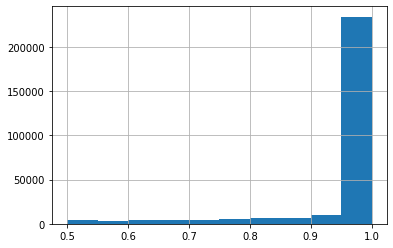

In [23]:
#check it makes a little sens...
df_preproc['type_prop'].hist(bins=10)

In [24]:
# default needed to avoid throwing error
df_preproc['label']=df_preproc['type_len'].apply(lambda dict_ : max(dict_,key=dict_.get,default=None))

In [25]:

df_preproc.label.value_counts()/len(df_preproc)

Evidence                0.534326
Concluding_Statement    0.134119
Claim                   0.126754
Lead                    0.051170
Position                0.027247
Counterclaim            0.019256
Rebuttal                0.017052
Name: label, dtype: float64

In [26]:
df.discourse_type.value_counts()/len(df)

Claim                   0.347959
Evidence                0.316731
Position                0.106859
Concluding_Statement    0.093594
Lead                    0.064487
Counterclaim            0.040314
Rebuttal                0.030057
Name: discourse_type, dtype: float64

In [27]:
df

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,is_not_sent,labels
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,1,Lead Lead Lead Lead Lead Lead Lead Lead. Lead ...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,1,Position Position Position Position Position P...
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,1,Evidence Evidence Evidence Evidence Evidence E...
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,1,Evidence Evidence Evidence Evidence Evidence E...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,1,Claim Claim Claim Claim Claim Claim Claim Clai...
...,...,...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1.618153e+12,2234.0,3203.0,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...,0,Evidence Evidence Evidence Evidence Evidence E...
144289,4C471936CD75,1.618153e+12,3221.0,4509.0,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...,0,Evidence Evidence Evidence Evidence Evidence E...
144290,4C471936CD75,1.618025e+12,4510.0,4570.0,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838,0,Position Position Position Position Position P...
144291,4C471936CD75,1.618025e+12,4570.0,4922.0,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...,1,Evidence Evidence Evidence Evidence Evidence E...


In [ ]:
### ISSUE ? 

# Model ! 

In [ ]:
## Intuition on transformers ? Only embedding ?

## Split the data

In [28]:
## We can not do a sample train test split : we would loose the connexion to our id ! Let's shuffle our df and create index

VAL_SPLIT = .8
TEST_SPLIT = .9

df_shuffled = df_preproc.sample(frac=1).reset_index(drop=True) #shuffle without replacement keeping all rows

LEN=len(df_shuffled)

idx_val=int(LEN*VAL_SPLIT)
idx_test=int(LEN*TEST_SPLIT)

idx_train=list(range(0,idx_val))
idx_val=list(range(idx_val,idx_test))
idx_test=list(range(idx_test,LEN))

assert(len(idx_test)+len(idx_train)+len(idx_val)==LEN)

In [29]:
## Create our train, val, test split

x_train = df_shuffled.loc[idx_train,'sentence'].values ## needs the .values to have an array, needed for the model
x_val = df_shuffled.loc[idx_val,'sentence'].values ## needs the .values to have an array, needed for the model
x_test = df_shuffled.loc[idx_test,'sentence'].values ## needs the .values to have an array, needed for the model

y_train = df_shuffled.loc[idx_train,'label'].values ## needs the .values to have an array, needed for the model
y_val = df_shuffled.loc[idx_val,'label'].values ## needs the .values to have an array, needed for the model
y_test = df_shuffled.loc[idx_test,'label'].values ## needs the .values to have an array, needed for the model



In [30]:
## Create OHE for y

#label mapping
list_labels = pd.Series(y_train.flatten()).unique() #Serie + simple
label_map = {l:i for i,l in enumerate(list_labels)}
label_map

y_train_mapped = np.vectorize(label_map.get)(y_train)
y_val_mapped = np.vectorize(label_map.get)(y_val)
y_test_mapped = np.vectorize(label_map.get)(y_test)


y_train_ohe = np.zeros((len(y_train),len(label_map)))
y_val_ohe = np.zeros((len(y_val),len(label_map)))
y_test_ohe = np.zeros((len(y_train),len(label_map)))

y_train_ohe[np.arange(len(y_train)),y_train_mapped]=1
y_val_ohe[np.arange(len(y_val)),y_val_mapped]=1
y_test_ohe[np.arange(len(y_test)),y_test_mapped]=1


## Let's try the simple way

In [31]:
x_train

array(['Author said that it can detect your facail expression by using a 3-D computer model of the face.',
       'Students may not like being forced to do things.',
       'in the United States."(paragraph 5) Exports mean to say that it is better for people to live in cities so they don\'t have to drive everywhere.',
       ...,
       'It says that it could modify the lesson like an efective human instructor but how far would it modify it.',
       'The best part of the system was that the teacher could save that lesson as a recording for us to go back and revise information at any time.',
       'Luke wanted to help the countrys gain back food and supplies so the would survive.'],
      dtype=object)

In [32]:
#tokenize

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_tok = tokenizer.texts_to_sequences(x_train)
x_val_tok = tokenizer.texts_to_sequences(x_val)
x_test_tok = tokenizer.texts_to_sequences(x_test)


In [ ]:
df_shuffled['len_sen']=df_shuffled['sentence'].apply(len)
df_shuffled['len_sen'].hist()
plt.plot([256,256],[0,15000],c='r')

In [ ]:
#padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_pad = pad_sequences(x_train_tok, dtype='float32', padding='post',maxlen=256)
x_val_pad = pad_sequences(x_val_tok, dtype='float32', padding='post',maxlen=256)
x_test_pad = pad_sequences(x_test_tok, dtype='float32', padding='post',maxlen=256)

In [ ]:
## Define variables for our embedding layer
vocab_size = len(tokenizer.word_index)
vocab_size

In [ ]:
def simple_model():
    
    inputs=tf.keras.layers.Input(shape=)
    
    x = tf.keras.layers.Embedding(input_dim=vocab_size + 1, output_dim=64, mask_zero=True)(inputs)
    x = tf.keras.layers.LSTM(units = 256, activation = 'tanh')(x)
    x = tf.keras.layers.Dense(58,activation='relu')(x)
    
    outputs = tf.keras.layers.Dense(8,activation='softmax')(x)

    return model 

## Transformers !

In [ ]:
from transformers import TFBertModel,AutoTokenizer
pretrained_bert = TFBertModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
x_train_tok=tokenizer(list(x_train),truncation=True,max_length=DISCOURSE_LEN,padding='max_length',
              return_token_type_ids=False,return_tensors='np')